In [1]:
import math
import os
import keras as k
import numpy as np
import pandas as pd

/home/sai/code/personal/py-snippets/.env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = k.applications.VGG16(weights = 'imagenet',include_top=False)
x = model.get_layer('block5_conv3').output
x = k.layers.GlobalAveragePooling2D()(x)
x = k.layers.Dense(256, activation='relu')(x)
x = k.layers.Dropout(0.5)(x)
x = k.layers.Dense(1, activation='sigmoid')(x)
model_final = k.models.Model(inputs=model.input, outputs=x)

In [3]:
for layer in model.layers:
    layer.trainable = False

In [4]:
model_final.compile(optimizer = k.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True),
                    loss      = 'binary_crossentropy',
                    metrics   = ['accuracy'])

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
datagen = ImageDataGenerator( 
    featurewise_center            = True,
    rescale                       = 1.,
    rotation_range                = 10,
    width_shift_range             = .1,
    height_shift_range            = .1,
    shear_range                   = 0.2,
    zoom_range                    = 0.2,
    horizontal_flip               = False,
    vertical_flip                 = False,
    fill_mode                     = "reflect")

# normalization neccessary for correct image input to VGG16
datagen.mean=np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape(1,1,3)

# no data augmentation for validation and test set
validgen = ImageDataGenerator(rescale=1., featurewise_center=True)
validgen.mean=np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape(1,1,3)

In [7]:
img_width  = 256
img_height = 256

train_data_dir      = "data/train"
validation_data_dir = "data/valid"
test_data_dir       = "data/test"

batch_size_train = 5
batch_size_val   = 15

train_gen = datagen.flow_from_directory(
        directory   = train_data_dir,
        target_size = (img_height, img_width),
        batch_size  = batch_size_train,
        class_mode  = "binary",
        shuffle     = True)

val_gen = validgen.flow_from_directory(
        directory   = validation_data_dir,
        target_size = (img_height, img_width),
        batch_size  = batch_size_val,
        class_mode  = "binary",
        shuffle     = False)

test_gen = validgen.flow_from_directory(
        directory   = test_data_dir,
        target_size = (img_height, img_width),
        batch_size  = batch_size_val,
        class_mode  = "binary",
        shuffle     = False)

train_samples      = len(train_gen.filenames)
validation_samples = len(val_gen.filenames)
test_samples       = len(test_gen.filenames)

Found 328 images belonging to 2 classes.
Found 131 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=15,
                           verbose=1,
                           min_delta=1e-4,
                           mode='min'),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=1e-4,
                               mode='min'),
             ModelCheckpoint(monitor='val_loss',
                             filepath='data/weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')]

In [9]:
model_final.fit_generator(generator        = train_gen,
                          epochs           = 50, 
                          steps_per_epoch  = math.ceil(train_samples / batch_size_train), 
                          validation_data  = val_gen, 
                          validation_steps = math.ceil(validation_samples / batch_size_val), 
                          verbose          = 2,
                          callbacks        = callbacks,
                          class_weight     = {0: 50/328, 1: 278/328})

Epoch 1/50
 - 12s - loss: 0.2922 - acc: 0.5081 - val_loss: 0.7859 - val_acc: 0.5420
Epoch 2/50
 - 8s - loss: 0.2327 - acc: 0.5717 - val_loss: 0.6413 - val_acc: 0.6336
Epoch 3/50
 - 8s - loss: 0.2051 - acc: 0.6364 - val_loss: 0.7878 - val_acc: 0.4809
Epoch 4/50
 - 8s - loss: 0.1904 - acc: 0.5889 - val_loss: 0.6554 - val_acc: 0.5573
Epoch 5/50
 - 8s - loss: 0.1689 - acc: 0.6627 - val_loss: 0.6663 - val_acc: 0.5496
Epoch 6/50
 - 8s - loss: 0.1369 - acc: 0.6969 - val_loss: 0.4541 - val_acc: 0.7786
Epoch 7/50
 - 8s - loss: 0.1474 - acc: 0.7243 - val_loss: 0.4700 - val_acc: 0.7710
Epoch 8/50
 - 8s - loss: 0.1448 - acc: 0.6849 - val_loss: 0.4022 - val_acc: 0.8473
Epoch 9/50
 - 8s - loss: 0.1245 - acc: 0.8041 - val_loss: 0.5328 - val_acc: 0.7099
Epoch 10/50
 - 8s - loss: 0.1369 - acc: 0.7131 - val_loss: 0.4738 - val_acc: 0.7710
Epoch 11/50
 - 8s - loss: 0.1176 - acc: 0.7788 - val_loss: 0.4556 - val_acc: 0.7786
Epoch 12/50
 - 8s - loss: 0.1329 - acc: 0.7242 - val_loss: 0.4455 - val_acc: 0.7939


In [10]:
model_final.load_weights('data/weights/best_weights.hdf5')

In [11]:
for layer in model_final.layers:
    layer.trainable = True

In [12]:
model_final.compile(optimizer = k.optimizers.SGD(lr=0.000001, momentum=0.9, nesterov=True),
                    loss      = 'binary_crossentropy',
                    metrics   = ['accuracy'])

In [13]:
model_final.fit_generator(generator        = train_gen,
                          epochs           = 50, 
                          steps_per_epoch  = math.ceil(train_samples / batch_size_train), 
                          validation_data  = val_gen, 
                          validation_steps = math.ceil(validation_samples / batch_size_val), 
                          verbose          = 2,
                          callbacks        = callbacks,
                          class_weight     = {0: 50/328, 1: 278/328})

Epoch 1/50
 - 22s - loss: 0.1322 - acc: 0.7950 - val_loss: 0.4075 - val_acc: 0.8321
Epoch 2/50
 - 19s - loss: 0.1332 - acc: 0.7859 - val_loss: 0.4143 - val_acc: 0.8321
Epoch 3/50
 - 20s - loss: 0.1246 - acc: 0.7869 - val_loss: 0.4189 - val_acc: 0.8092
Epoch 4/50
 - 19s - loss: 0.1367 - acc: 0.7828 - val_loss: 0.4230 - val_acc: 0.8015
Epoch 5/50
 - 19s - loss: 0.1366 - acc: 0.7757 - val_loss: 0.4304 - val_acc: 0.8015

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 6/50
 - 19s - loss: 0.1146 - acc: 0.7980 - val_loss: 0.4299 - val_acc: 0.8015
Epoch 7/50
 - 19s - loss: 0.1418 - acc: 0.7818 - val_loss: 0.4305 - val_acc: 0.8015
Epoch 8/50
 - 19s - loss: 0.1581 - acc: 0.7182 - val_loss: 0.4315 - val_acc: 0.8015

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 9/50
 - 19s - loss: 0.1207 - acc: 0.7737 - val_loss: 0.4314 - val_acc: 0.8015
Epoch 10/50
 - 19s - loss: 0.1341 - acc: 0.8060 - val_loss: 0.4314 - val_acc: 0.8

In [20]:
model_final.load_weights('data/weights/best_weights.hdf5')

In [21]:
test_gen = validgen.flow_from_directory(
        directory   = test_data_dir,
        target_size = (img_height, img_width),
        batch_size  = 32,
        class_mode  = "binary",
        shuffle     = False)
test_samples = len(test_gen.filenames)
preds = model_final.predict_generator(test_gen, math.ceil(test_samples / 32))

Found 198 images belonging to 2 classes.


In [22]:
preds = [x[0] for x in preds]

In [23]:
from sklearn.metrics import roc_auc_score

In [24]:
roc_auc_score(test_gen.classes, preds)

0.7365269461077844

In [25]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_gen.classes, preds)

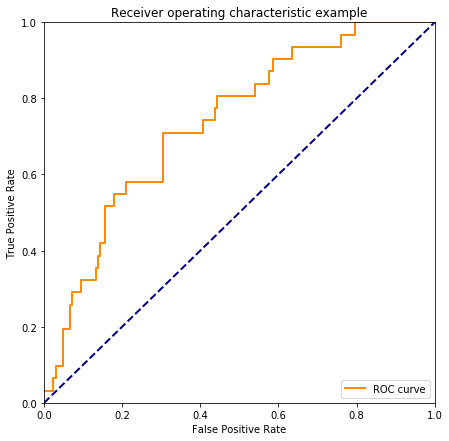

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()